In [1]:
import nest_asyncio
nest_asyncio.apply()
import multiprocessing
multiprocessing.set_start_method("fork")
import pandas as pd
import stan
import numpy as np
from scipy.stats import pearsonr

from scipy.special import expit
import matplotlib.pyplot as plt
import arviz as az

# Emma notes (8/22):

In general, let's build complexity iteratively. Start by getting reasonable results without worrying about ICAR prior/smoothing. Then use standard ICAR prior (with weight 0.5). Then use full CAR (maybe). Data generation code is reviewed + model without proper CAR prior is reviewed. Another thing it might be nice to implement at some point is using the information about where the annotated images are (i.e., what Census tracts). Could incorporate this as a multinomial (potentially?) 

Model with simple L2 smoothing (or no smoothing at all - stan_code_with_weighted_ICAR_prior):

1. Consistently recovers parameters for realistic parameter settings (with no smoothing)
2. Reviewed Stan code and looks good. 
3. ALso implemented L2 regularization for adjacent Census tracts. This isn't actually the "proper" way to do it, but might be useful on real data. Haven't tested how this performs. 

Model wih full CAR prior (stan_code_proper_car_prior):

1. Haven't reviewed this or verified it recovers correct params (recently; I think I did a while ago). When you do review, don't need to re-review all the Bayesian conditioning math; it should be pretty similar to the old code. 


In [2]:
# Stan code with CAR prior seems to work but hasn't been reviewed. 
# CAR prior is https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html
stan_code_proper_car_prior = '''
functions {
  /**
  * Return the log probability of a proper conditional autoregressive (CAR) prior 
  * with a sparse representation for the adjacency matrix
  *
  * @param phi Vector containing the parameters with a CAR prior
  * @param tau Precision parameter for the CAR prior (real)
  * @param alpha Dependence (usually spatial) parameter for the CAR prior (real)
  * @param W_sparse Sparse representation of adjacency matrix (int array)
  * @param n Length of phi (int)
  * @param W_n Number of adjacent pairs (int)
  * @param D_sparse Number of neighbors for each location (vector)
  * @param lambda Eigenvalues of D^{-1/2}*W*D^{-1/2} (vector)
  *
  * @return Log probability density of CAR prior up to additive constant
  */
  real sparse_car_lpdf(vector phi, real tau, real alpha,
                       array[,] int W_sparse, vector D_sparse, vector lambda,
                       int n, int W_n) {
    row_vector[n] phit_D; // phi' * D
    row_vector[n] phit_W; // phi' * W
    vector[n] ldet_terms;
    
    phit_D = (phi .* D_sparse)';
    phit_W = rep_row_vector(0, n);
    for (i in 1 : W_n) {
      phit_W[W_sparse[i, 1]] = phit_W[W_sparse[i, 1]] + phi[W_sparse[i, 2]];
      phit_W[W_sparse[i, 2]] = phit_W[W_sparse[i, 2]] + phi[W_sparse[i, 1]];
    }
    
    for (i in 1 : n) {
      ldet_terms[i] = log1m(alpha * lambda[i]);
    }
    return 0.5
           * (n * log(tau) + sum(ldet_terms)
              - tau * (phit_D * phi - alpha * (phit_W * phi)));
  }
}

data {
  int<lower=0> N;
  int<lower=0> N_edges;
  matrix<lower=0, upper=1>[N, N] W; // adjacency matrix
  int W_n; // number of adjacent region pairs
  array[N] int<lower=0> n_images; 
  array[N] int<lower=0> n_classified_positive; 

  //annotation sample. 
  int n_annotated_classified_negative;
  int n_annotated_classified_positive;
  int n_annotated_classified_negative_true_positive;
  int n_annotated_classified_positive_true_positive;  
}
transformed data {
  array[W_n, 2] int W_sparse; // adjacency pairs
  vector[N] D_sparse; // diagonal of D (number of neigbors for each site)
  vector[N] lambda; // eigenvalues of invsqrtD * W * invsqrtD
  
  {
    // generate sparse representation for W
    int counter;
    counter = 1;
    // loop over upper triangular part of W to identify neighbor pairs
    for (i in 1 : (N - 1)) {
      for (j in (i + 1) : N) {
        if (W[i, j] == 1) {
          W_sparse[counter, 1] = i;
          W_sparse[counter, 2] = j;
          counter = counter + 1;
        }
      }
    }
  }
  for (i in 1 : N) {
    D_sparse[i] = sum(W[i]);
  }
  {
    vector[N] invsqrtD;
    for (i in 1 : N) {
      invsqrtD[i] = 1 / sqrt(D_sparse[i]);
    }
    lambda = eigenvalues_sym(quad_form(W, diag_matrix(invsqrtD)));
  }
}

parameters {
  vector[N] phi;
  real<lower=0> tau;
  real<lower=0, upper=1> alpha;
  real <upper=0>phi_offset; // you may not want to place this constraint but it helps convergence with small numbers of samples
  real<lower=0, upper=1> p_y_1_given_y_hat_1; 
  real<lower=0, upper=1> p_y_1_given_y_hat_0;
}
transformed parameters {
    vector[N] p_y = inv_logit(phi + phi_offset);
    //real predicted_overall_p_y = sum(n_images .* p_y) / sum(n_images);
    real empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images);
    real p_y_hat_1_given_y_1 = empirical_p_yhat * p_y_1_given_y_hat_1 / (empirical_p_yhat * p_y_1_given_y_hat_1 + (1 - empirical_p_yhat) * p_y_1_given_y_hat_0);
    real p_y_hat_1_given_y_0 = empirical_p_yhat * (1 - p_y_1_given_y_hat_1) / (empirical_p_yhat * (1 - p_y_1_given_y_hat_1) + (1 - empirical_p_yhat) * (1 - p_y_1_given_y_hat_0));
}
model {
  n_annotated_classified_negative_true_positive ~ binomial(n_annotated_classified_negative , p_y_1_given_y_hat_0);
  n_annotated_classified_positive_true_positive ~ binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1);
  tau ~ gamma(2, 2);
  phi ~ sparse_car(tau, alpha, W_sparse, D_sparse, lambda, N, W_n);
  phi_offset ~ normal(-4, 0.5);
  n_classified_positive ~ binomial(n_images, p_y .* p_y_hat_1_given_y_1 + (1 - p_y) .* p_y_hat_1_given_y_0);
}
'''

# Stan code below works and has been reviewed but does not implement a proper ICAR prior. Set variable use_ICAR_prior to 0 if you don't want to use one at all. 
# I think it might also be principled to set the ICAR prior weight to 0.5, https://mc-stan.org/users/documentation/case-studies/icar_stan.html. 
stan_code_with_weighted_ICAR_prior = '''
data {
  int<lower=0> N; // number of Census tracts. 
  int<lower=0> N_edges; // number of edges in the graph (i.e. number of pairs of adjacent Census tracts). 
  array[N_edges] int<lower=1, upper=N> node1; // node1[i] adjacent to node2[i]
  array[N_edges] int<lower=1, upper=N> node2; // and node1[i] < node2[i]
  array[N] int<lower=0> n_images; // vector with one entry per Census tract of the number of images in that tract. 
  array[N] int<lower=0> n_classified_positive; // vector with one entry per Census tract of number of images classified positive. 
  int<lower=0,upper=1> use_ICAR_prior; // 1 if you want to use ICAR prior, 0 if you don't. ICAR prior basically smooths the data. 
  real <lower=0> ICAR_prior_weight; // weight of ICAR prior.

  //annotation sample. 
  int n_annotated_classified_negative;
  int n_annotated_classified_positive;
  int n_annotated_classified_negative_true_positive;
  int n_annotated_classified_positive_true_positive;  
}
parameters {
  vector[N] phi;
  real<upper=0> phi_offset; // this is the mean from which phis are drawn. Upper bound at 0 to rule out bad modes and set prior that true positives are rare. 
  ordered[2] logit_p_y_1_given_y_hat; // ordered to impose the constraint that p_y_1_given_y_hat_0 < p_y_1_given_y_hat_1.
}
transformed parameters {
    real p_y_1_given_y_hat_0 = inv_logit(logit_p_y_1_given_y_hat[1]);
    real p_y_1_given_y_hat_1 = inv_logit(logit_p_y_1_given_y_hat[2]);
    vector[N] p_y = inv_logit(phi);
    real empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images);
    real p_y_hat_1_given_y_1 = empirical_p_yhat * p_y_1_given_y_hat_1 / (empirical_p_yhat * p_y_1_given_y_hat_1 + (1 - empirical_p_yhat) * p_y_1_given_y_hat_0);
    real p_y_hat_1_given_y_0 = empirical_p_yhat * (1 - p_y_1_given_y_hat_1) / (empirical_p_yhat * (1 - p_y_1_given_y_hat_1) + (1 - empirical_p_yhat) * (1 - p_y_1_given_y_hat_0));
}
model {
  // You can't just scale ICAR priors by random numbers; the only principled value for ICAR_prior_weight is 0.5. 
  // https://stats.stackexchange.com/questions/333258/strength-parameter-in-icar-spatial-model
  // still, there's no computational reason you can't use another value. 
  if (use_ICAR_prior == 1) {
    target += -ICAR_prior_weight * dot_self(phi[node1] - phi[node2]);
  }

  // model the results on the annotation set. 
  n_annotated_classified_negative_true_positive ~ binomial(n_annotated_classified_negative, p_y_1_given_y_hat_0);
  n_annotated_classified_positive_true_positive ~ binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1);
  
  // model the results by Census tract. 
  logit_p_y_1_given_y_hat ~ normal(0, 2);
  phi_offset ~ normal(0, 2);
  phi ~ normal(phi_offset, 1); 
  n_classified_positive ~ binomial(n_images, p_y .* p_y_hat_1_given_y_1 + (1 - p_y) .* p_y_hat_1_given_y_0);
}
'''

empirical_p_y 0.24282846959991516
empirical_p_yhat 0.16329877391093794
p_y_hat_1_given_y_1 0.6399910926383932
p_y_hat_1_given_y_0 0.010246777316759074
p_y_1_given_y_hat_1 0.9516792677679077
p_y_1_given_y_hat_0 0.10448223247571914
number of annotated classified negative which were positive: 64/500
number of annotated classified positive which were positive: 479/500
Building...

In file included from /Users/emmapierson/Library/Caches/httpstan/4.12.0/models/dd3ri7vs/model_dd3ri7vs.cpp:2:
In file included from /Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/httpstan/include/stan/math/rev.hpp:4:
In file included from /Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:23:
In file included from /Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/httpstan/include/Eigen/Sparse:26:
In file included from /Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/httpstan/include/Eigen/SparseCore:61:
/User

9 warnings generated.

Building: 11.1s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   6% (700/12000)
Sampling:   8% (900/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1500/12000)
Sampling:  14% (1700/12000)
Sampling:  16% (1900/12000)
Sampling:  18% (2200/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3400/12000)
Sampling:  30% (3600/12000)
Sampling:  31% (3700/12000)
Sampling:  32% (3900/12000)
Sampling:  34% (4100/12000)
Sampling:  36% (4300/12000)
Sampling:  37% (4400/12000)
Sampling:  38% (4600/12000)
Sampling:  40% (4800/12000)
Sampling:  42% (5000/12000)
Sampling:  43

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.590  0.016   0.563    0.622      0.002    0.002   
p_y_hat_1_given_y_0  0.008  0.001   0.006    0.011      0.000    0.000   
phi_offset          -1.220  0.055  -1.321   -1.117      0.006    0.004   
p_y_1_given_y_hat_1  0.963  0.006   0.953    0.974      0.000    0.000   
p_y_1_given_y_hat_0  0.131  0.009   0.115    0.147      0.001    0.001   
empirical_p_yhat     0.163  0.000   0.163    0.163      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      62.0     220.0   1.08  
p_y_hat_1_given_y_0     573.0    1178.0   1.00  
phi_offset               96.0     424.0   1.05  
p_y_1_given_y_hat_1     438.0    1013.0   1.00  
p_y_1_given_y_hat_0      63.0     218.0   1.08  
empirical_p_yhat       4000.0    4000.0    NaN  


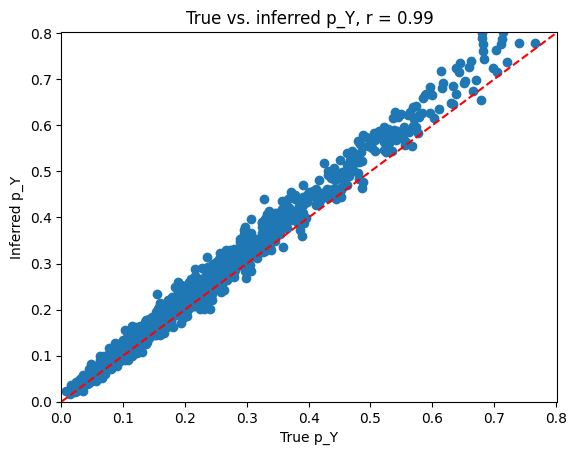

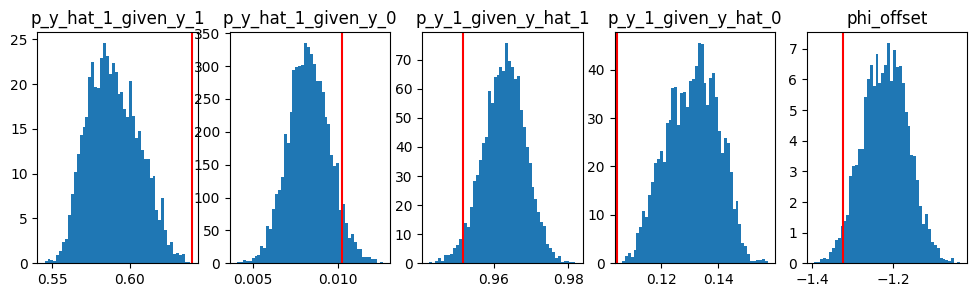

empirical_p_y 0.15028969491613725
empirical_p_yhat 0.11346743224004352
p_y_hat_1_given_y_1 0.6760184964593481
p_y_hat_1_given_y_0 0.01399181853297447
p_y_1_given_y_hat_1 0.8953988962718971
p_y_1_given_y_hat_0 0.05492305990362663
number of annotated classified negative which were positive: 30/500
number of annotated classified positive which were positive: 440/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (203/12000)
Sampling:   3% (302/12000)
Sampling:   3% (401/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  15% (1800/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)
Sampling:  28% (3400/12000)
Sampling:  29% (3500/12000)
Sampling:  30% (3600/12000)
Sampling:  32% (3800/12000)
Sampling:  33% (4000/12000)


                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.666  0.034   0.600    0.732      0.010    0.008   
p_y_hat_1_given_y_0  0.013  0.001   0.012    0.015      0.000    0.000   
phi_offset          -2.026  0.077  -2.175   -1.883      0.022    0.016   
p_y_1_given_y_hat_1  0.900  0.007   0.886    0.913      0.001    0.001   
p_y_1_given_y_hat_0  0.058  0.009   0.039    0.075      0.003    0.002   
empirical_p_yhat     0.113  0.000   0.113    0.113      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      11.0      24.0   1.29  
p_y_hat_1_given_y_0     191.0    1226.0   1.03  
phi_offset               12.0      30.0   1.24  
p_y_1_given_y_hat_1      58.0     915.0   1.05  
p_y_1_given_y_hat_0      11.0      25.0   1.30  
empirical_p_yhat       4000.0    4000.0    NaN  


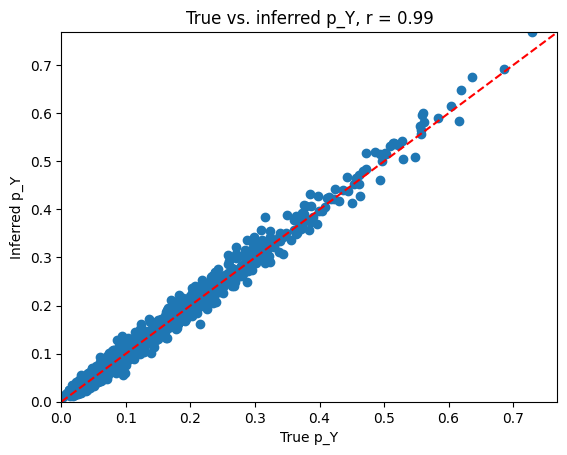

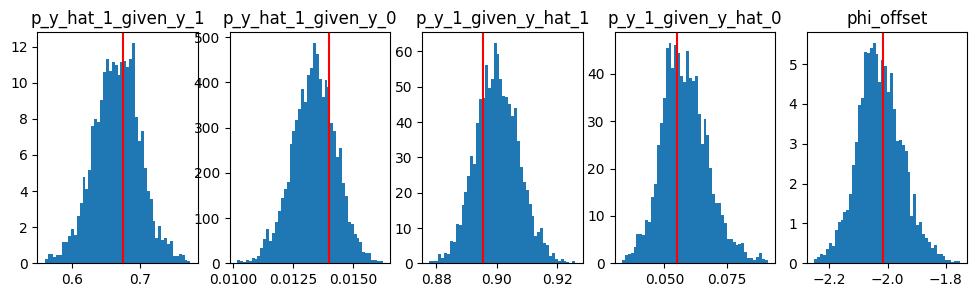

empirical_p_y 0.054275945498917844
empirical_p_yhat 0.04177635824945742
p_y_hat_1_given_y_1 0.5487564831633407
p_y_hat_1_given_y_0 0.012489862388248492
p_y_1_given_y_hat_1 0.7129457477959591
p_y_1_given_y_hat_0 0.02555944923444347
number of annotated classified negative which were positive: 12/500
number of annotated classified positive which were positive: 354/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   2% (203/12000)
Sampling:   3% (302/12000)
Sampling:   3% (402/12000)
Sampling:   5% (601/12000)
Sampling:   6% (701/12000)
Sampling:   8% (900/12000)
Sampling:   9% (1100/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)
Sampling:  28% (3400/12000)
Sampling:  29% (3500/12000)
Sampling:  30% (3600/12000

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.602  0.061   0.488    0.711      0.019    0.014   
p_y_hat_1_given_y_0  0.012  0.000   0.012    0.013      0.000    0.000   
phi_offset          -3.395  0.123  -3.621   -3.174      0.037    0.027   
p_y_1_given_y_hat_1  0.718  0.010   0.700    0.736      0.001    0.001   
p_y_1_given_y_hat_0  0.021  0.006   0.012    0.032      0.002    0.001   
empirical_p_yhat     0.042  0.000   0.042    0.042      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      10.0      84.0   1.34  
p_y_hat_1_given_y_0     852.0    2088.0   1.01  
phi_offset               11.0      79.0   1.31  
p_y_1_given_y_hat_1     148.0    1328.0   1.04  
p_y_1_given_y_hat_0      10.0      76.0   1.35  
empirical_p_yhat       4000.0    4000.0    NaN  


/Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


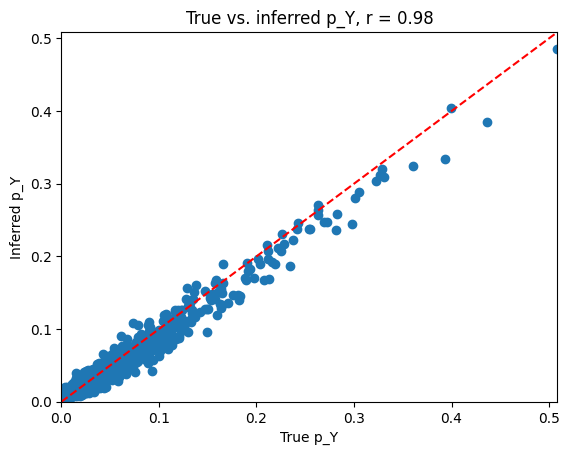

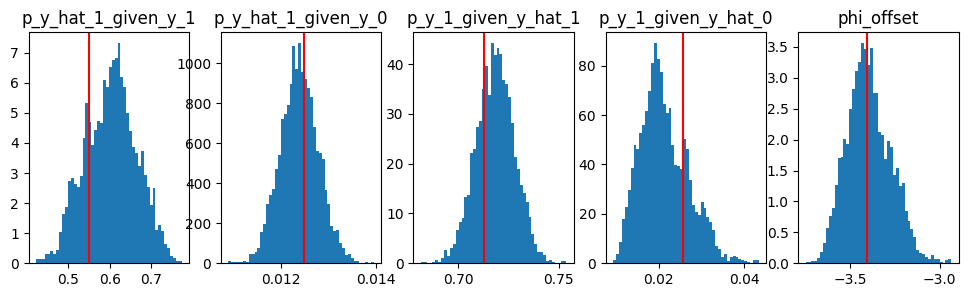

empirical_p_y 0.28291596082345155
empirical_p_yhat 0.12299772196810756
p_y_hat_1_given_y_1 0.4052069443257606
p_y_hat_1_given_y_0 0.01102897537790102
p_y_1_given_y_hat_1 0.9320458147670622
p_y_1_given_y_hat_0 0.1918768662891372
number of annotated classified negative which were positive: 95/500
number of annotated classified positive which were positive: 476/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   2% (203/12000)
Sampling:   3% (302/12000)
Sampling:   4% (501/12000)
Sampling:   5% (600/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   9% (1100/12000)
Sampling:  11% (1300/12000)
Sampling:  13% (1600/12000)
Sampling:  15% (1800/12000)
Sampling:  17% (2000/12000)
Sampling:  19% (2300/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2700/12000)
Sampling:  24% (2900/12000)
Sampling:  26% (3100/12000)
Sampling:  28% (3300/12000)
Sampling:  29% (3500/12000)
Sampling:  32% (3800/12000)
Sampling:  33% (4000/12000)
Sampling:  35% (4200/12000)
Sampling:  37% (4400/12000)
Sampling:  38% (4600/12000)
Sampling:  40% (4800/12000)
Sampling:  42% (5000/12000)
Sampling:  43% (5200/12000)
Sampling:  46% (5500/12000)
Sampling:  48% (5800/12000)
Sampling:  51% (6100/12000)
Sampling:  53% (6400/12000

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.402  0.011   0.383    0.422      0.002    0.001   
p_y_hat_1_given_y_0  0.009  0.001   0.007    0.011      0.000    0.000   
phi_offset          -1.069  0.056  -1.185   -0.974      0.007    0.005   
p_y_1_given_y_hat_1  0.946  0.007   0.933    0.960      0.001    0.000   
p_y_1_given_y_hat_0  0.198  0.009   0.181    0.215      0.001    0.001   
empirical_p_yhat     0.123  0.000   0.123    0.123      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      52.0      56.0   1.05  
p_y_hat_1_given_y_0     166.0     566.0   1.02  
phi_offset               59.0      98.0   1.04  
p_y_1_given_y_hat_1     129.0     490.0   1.03  
p_y_1_given_y_hat_0      46.0      60.0   1.05  
empirical_p_yhat       4000.0    4000.0    NaN  


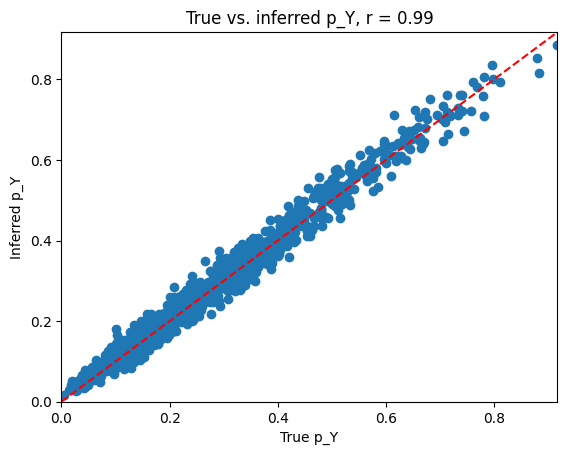

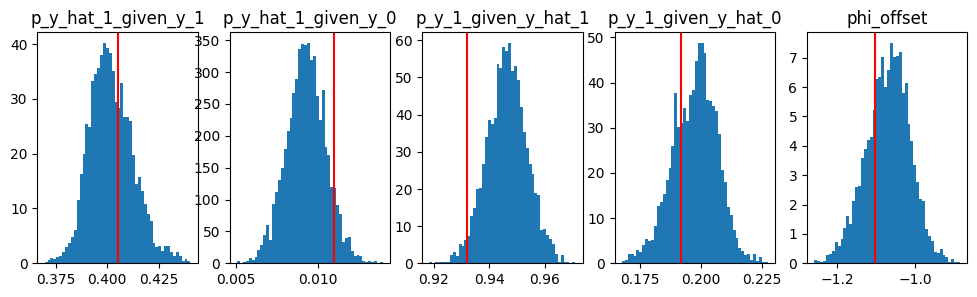

empirical_p_y 0.2579095675032785
empirical_p_yhat 0.07332948553926301
p_y_hat_1_given_y_1 0.23226458200862787
p_y_hat_1_given_y_0 0.018160621726981116
p_y_1_given_y_hat_1 0.8169054705845551
p_y_1_given_y_hat_0 0.21367498643930688
number of annotated classified negative which were positive: 96/500
number of annotated classified positive which were positive: 409/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   2% (203/12000)
Sampling:   3% (302/12000)
Sampling:   4% (501/12000)
Sampling:   6% (700/12000)
Sampling:   8% (900/12000)
Sampling:   9% (1100/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  15% (1800/12000)
Sampling:  18% (2100/12000)
Sampling:  19% (2300/12000)
Sampling:  21% (2500/12000)
Sampling:  23% (2800/12000)
Sampling:  25% (3000/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3400/12000)
Sampling:  29% (3500/12000)
Sampling:  32% (3800/12000)
Sampling:  33% (4000/12000)
Sampling:  35% (4200/12000)
Sampling:  38% (4500/12000)
Sampling:  39% (4700/12000)
Sampling:  42% (5000/12000)
Sampling:  43% (5200/12000)
Sampling:  45% (5400/12000)
Sampling:  48% (5700/12000)
Sampling:  50% (6000/12000)
Sampling:  52% (6200/12000)
Sampling:  54% (6500/1200

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.251  0.008   0.236    0.266      0.001    0.001   
p_y_hat_1_given_y_0  0.018  0.001   0.016    0.019      0.000    0.000   
phi_offset          -1.383  0.065  -1.500   -1.262      0.007    0.005   
p_y_1_given_y_hat_1  0.816  0.010   0.798    0.834      0.001    0.001   
p_y_1_given_y_hat_0  0.193  0.009   0.175    0.210      0.001    0.001   
empirical_p_yhat     0.073  0.000   0.073    0.073      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      80.0     227.0   1.02  
p_y_hat_1_given_y_0     269.0    1147.0   1.01  
phi_offset               86.0     354.0   1.02  
p_y_1_given_y_hat_1     146.0     570.0   1.02  
p_y_1_given_y_hat_0      69.0     209.0   1.03  
empirical_p_yhat       4000.0    4000.0    NaN  


/Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


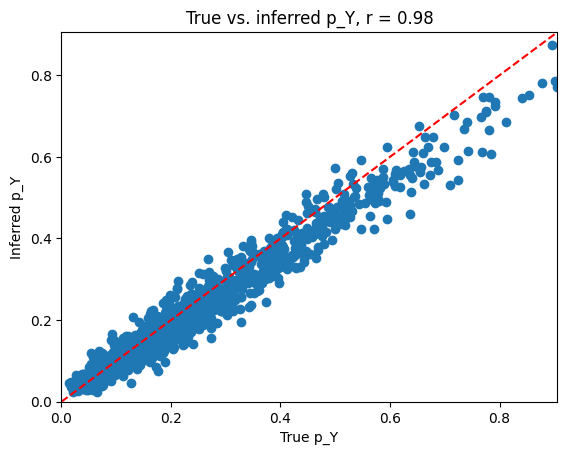

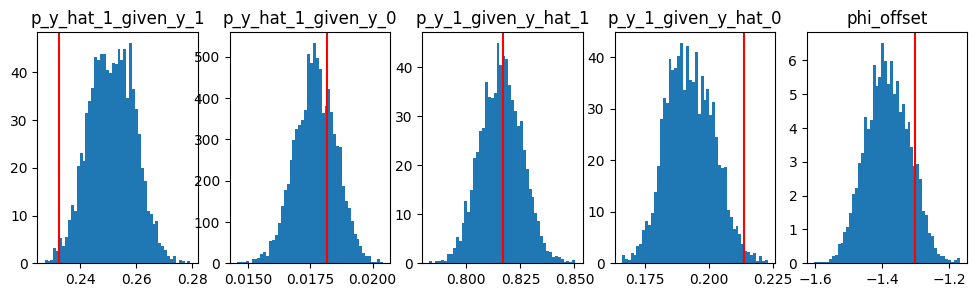

empirical_p_y 0.07438762049822434
empirical_p_yhat 0.056624039539519014
p_y_hat_1_given_y_1 0.5982816335802762
p_y_hat_1_given_y_0 0.012996979066401505
p_y_1_given_y_hat_1 0.7859691302801979
p_y_1_given_y_hat_0 0.03167652626404705
number of annotated classified negative which were positive: 11/500
number of annotated classified positive which were positive: 405/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (401/12000)
Sampling:   4% (501/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   8% (900/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)
Sampling:  28% (3400/12000)
Sampling:  30% (3600/12000)
Sampling:  31% (3700/12000)


In [3]:
import random
def generate_simulated_data(N, images_per_location, 
                            n_annotated_classified_negative, 
                            n_annotated_classified_positive, 
                            icar_prior_setting):
    """
    Generate simulated data for the model.
    """    
    node1 = []
    node2 = []
    for i in range(N):
        for j in range(i+1, N):
            if np.random.rand() < 0.1:
                node1.append(i + 1) # one indexing for Stan. 
                node2.append(j + 1)
    phi_offset = random.random() * -3 - 1 # mean of phi.

    # these only matter for CAR model. https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html
    D = np.zeros((N, N))
    W = np.zeros((N, N))
    for i in range(len(node1)):
        D[node1[i] - 1, node1[i] - 1] += 1
        D[node2[i] - 1, node2[i] - 1] += 1
        W[node1[i] - 1, node2[i] - 1] = 1
        W[node2[i] - 1, node1[i] - 1] = 1
    B = np.linalg.inv(D) @ W
    tau = np.random.gamma(scale=0.2, shape=2)
    alpha = np.random.random()
    sigma = np.linalg.inv(tau * D @ (np.eye(N) - alpha * B))
    if icar_prior_setting != 'none':    
        phi = np.random.multivariate_normal(mean=np.zeros(N), cov=sigma)
    else:
        phi = np.random.normal(loc=0, size=N) # this uses no icar prior, just draws everything independently. 
    p_Y = expit(phi + phi_offset)
    n_images = np.random.poisson(images_per_location, N)
    p_y_hat_1_given_y_1 = random.random() * 0.5 + 0.2
    p_y_hat_1_given_y_0 = random.random() * 0.01 + 0.01

    n_classified_positive = []
    n_true_positive = []
    for i in range(N):
        n_true_positive.append(np.random.binomial(n_images[i], p_Y[i]))
        n_classified_positive.append(np.random.binomial(n_true_positive[-1], p_y_hat_1_given_y_1) + 
                                    np.random.binomial(n_images[i] - n_true_positive[-1], p_y_hat_1_given_y_0))
    empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images)
    empirical_p_y = sum(n_true_positive) * 1.0 / sum(n_images)
    p_y_1_given_y_hat_1 = p_y_hat_1_given_y_1 * empirical_p_y / empirical_p_yhat
    p_y_1_given_y_hat_0 = (1 - p_y_hat_1_given_y_1) * empirical_p_y / (1 - empirical_p_yhat)
    print("empirical_p_y", empirical_p_y)
    print("empirical_p_yhat", empirical_p_yhat)
    print("p_y_hat_1_given_y_1", p_y_hat_1_given_y_1)
    print("p_y_hat_1_given_y_0", p_y_hat_1_given_y_0)
    print("p_y_1_given_y_hat_1", p_y_1_given_y_hat_1)
    print("p_y_1_given_y_hat_0", p_y_1_given_y_hat_0)
                     
    n_annotated_classified_negative_true_positive = np.random.binomial(n_annotated_classified_negative, p_y_1_given_y_hat_0)
    n_annotated_classified_positive_true_positive = np.random.binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1)
    print("number of annotated classified negative which were positive: %i/%i" % (n_annotated_classified_negative_true_positive, n_annotated_classified_negative))
    print("number of annotated classified positive which were positive: %i/%i" % (n_annotated_classified_positive_true_positive, n_annotated_classified_positive))
    

    return {'observed_data':{'N':N, 'N_edges':len(node1), 'node1':node1, 'node2':node2, 
                             'n_images':n_images, 'n_classified_positive':n_classified_positive, 
                             'n_annotated_classified_negative':n_annotated_classified_negative,
                                'n_annotated_classified_positive':n_annotated_classified_positive,
                                'n_annotated_classified_negative_true_positive':n_annotated_classified_negative_true_positive,
                                'n_annotated_classified_positive_true_positive':n_annotated_classified_positive_true_positive},

            'parameters':{'phi':phi, 'phi_offset':phi_offset, 
                          'p_y_1_given_y_hat_1':p_y_1_given_y_hat_1,
                            'p_y_1_given_y_hat_0':p_y_1_given_y_hat_0, 
                            'p_y_hat_1_given_y_1':p_y_hat_1_given_y_1,
                            'p_y_hat_1_given_y_0':p_y_hat_1_given_y_0, 
                            'p_Y':p_Y, 
                            'tau':tau, 'alpha':alpha, 'sigma':sigma}}

icar_prior_setting = 'none'
assert icar_prior_setting in ['none', 'cheating', 'proper']
for i in range(10):
    NUM_WARMUP = 2000
    NUM_SAMPLES = 1000
    N = 1000
    simulated_data = generate_simulated_data(N=N, 
                                                images_per_location=1000, 
                                                n_annotated_classified_negative=500, 
                                                n_annotated_classified_positive=500, 
                                                icar_prior_setting=icar_prior_setting)
    if icar_prior_setting == 'proper':
        raise Exception("Haven't verified that this model actually works! Need to review it / check on simulated data. No need to review the parts which are identical to the other model.")
        W = np.zeros((N, N))
        
        for i in range(len(simulated_data['observed_data']['node1'])):
            W[simulated_data['observed_data']['node1'][i] - 1, 
                                simulated_data['observed_data']['node2'][i] - 1] = 1
            W[simulated_data['observed_data']['node2'][i] - 1, 
                                simulated_data['observed_data']['node1'][i] - 1] = 1
        del simulated_data['observed_data']['node1']
        del simulated_data['observed_data']['node2']
        simulated_data['observed_data']['W'] = W
        simulated_data['observed_data']['W_n'] = int(W.sum() / 2)
        model = stan.build(stan_code_proper_car_prior, data=simulated_data['observed_data'])
    elif icar_prior_setting == 'cheating':
        simulated_data['observed_data']['use_ICAR_prior'] = 1
        simulated_data['observed_data']['ICAR_prior_weight'] = 0.05
        model = stan.build(stan_code_with_weighted_ICAR_prior, data=simulated_data['observed_data'])
    elif icar_prior_setting == 'none':
        simulated_data['observed_data']['use_ICAR_prior'] = 0
        simulated_data['observed_data']['ICAR_prior_weight'] = 0
        model = stan.build(stan_code_with_weighted_ICAR_prior, data=simulated_data['observed_data'])
    else:
        raise ValueError("Invalid icar_prior_options", icar_prior_setting)
    fit = model.sample(num_chains=4, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)
    print(az.summary(fit, var_names=['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 'phi_offset', 
                                    'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
                                    'empirical_p_yhat']))

    df = fit.to_frame()

    inferred_p_y = [df[f'p_y.{i}'].mean() for i in range(1, N + 1)]
    plt.scatter(simulated_data['parameters']['p_Y'], inferred_p_y)
    plt.title("True vs. inferred p_Y, r = %.2f" %
            pearsonr(simulated_data['parameters']['p_Y'], inferred_p_y)[0])
    max_val = max(max(simulated_data['parameters']['p_Y']), max(inferred_p_y))
    plt.xlabel("True p_Y")
    plt.ylabel("Inferred p_Y")
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlim([0, max_val])
    plt.ylim([0, max_val])
    plt.figure(figsize=[12, 3])
    if icar_prior_setting == 'proper':
        param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset', 'alpha', 'tau']
    else:
        param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset']
    for k in param_names:
        plt.subplot(1, len(param_names), param_names.index(k) + 1)
        # histogram of posterior samples
        plt.hist(df[k], bins=50, density=True)
        plt.title(k)
        plt.axvline(simulated_data['parameters'][k], color='red')
    plt.show()
    #az.plot_trace(fit, var_names=['sigma_Z'])




# Code below here is deprecated. 

In [ ]:
# Stan code below "works" but cheats on the ICAR prior. Set variable use_ICAR_prior to 0 if you don't want to use one at all.  
DEPRECATED_stan_code_cheating_ICAR_prior_with_soft_zero_constraint = '''
data {
  int<lower=0> N;
  int<lower=0> N_edges;
  array[N_edges] int<lower=1, upper=N> node1; // node1[i] adjacent to node2[i]
  array[N_edges] int<lower=1, upper=N> node2; // and node1[i] < node2[i]
  array[N] int<lower=0> n_images; 
  array[N] int<lower=0> n_classified_positive; 
  int<lower=0,upper=1> use_ICAR_prior; // 1 if you want to use ICAR prior, 0 if you don't. ICAR prior basically smooths the data. 
  real <lower=0> ICAR_prior_weight; // weight of ICAR prior.

  //annotation sample. 
  int n_annotated_classified_negative;
  int n_annotated_classified_positive;
  int n_annotated_classified_negative_true_positive;
  int n_annotated_classified_positive_true_positive;  
}
parameters {
  vector[N] phi;
  real phi_offset; 
  real<lower=0, upper=1> p_y_1_given_y_hat_1; 
  real<lower=0, upper=1> p_y_1_given_y_hat_0;
}
transformed parameters {
    vector[N] p_y = inv_logit(phi + phi_offset);
    //real predicted_overall_p_y = sum(n_images .* p_y) / sum(n_images);
    real empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images);
    real p_y_hat_1_given_y_1 = empirical_p_yhat * p_y_1_given_y_hat_1 / (empirical_p_yhat * p_y_1_given_y_hat_1 + (1 - empirical_p_yhat) * p_y_1_given_y_hat_0);
    real p_y_hat_1_given_y_0 = empirical_p_yhat * (1 - p_y_1_given_y_hat_1) / (empirical_p_yhat * (1 - p_y_1_given_y_hat_1) + (1 - empirical_p_yhat) * (1 - p_y_1_given_y_hat_0));
}
model {

  // You can't just scale ICAR priors by random numbers, so this is "cheating". Still, maybe a good sanity check. 
  // https://stats.stackexchange.com/questions/333258/strength-parameter-in-icar-spatial-model
  if (use_ICAR_prior == 1) {
    target += -ICAR_prior_weight * dot_self(phi[node1] - phi[node2]);
  }
  n_annotated_classified_negative_true_positive ~ binomial(n_annotated_classified_negative, p_y_1_given_y_hat_0);
  n_annotated_classified_positive_true_positive ~ binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1);
  
  // soft sum-to-zero constraint on phi,
  // equivalent to mean(phi) ~ normal(0,0.01)
  phi_offset ~ normal(0, 2);
  //sum(phi) ~ normal(0, 0.01 * N); // ZERO CENTERED.
  n_classified_positive ~ binomial(n_images, p_y .* p_y_hat_1_given_y_1 + (1 - p_y) .* p_y_hat_1_given_y_0);
}
'''
